In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# 策略盈亏分析

--------------backtesting timing2--------------
                         ret        sp         dd  dd_start    dd_end  \
from     to                                                             
20180102 20181228   0.612361  0.024298  22.681417  20180115  20180620   
20190102 20191231  35.400607  1.477469  10.239256  20190520  20190613   
20200102 20201231  46.788850  1.541399  18.125155  20200121  20200204   
20210104 20211231  -1.299363 -0.064705  19.087687  20210115  20210226   
20220104 20221230  22.374956  0.900278  20.089338  20220419  20220427   
20230103 20231229  23.487365  1.423758  10.099294  20230607  20230705   
20240102 20241231  29.487916  0.765967  29.706160  20240122  20240206   
20250102 20250411  31.091211  0.978048  17.835418  20250307  20250409   
20180102 20250411  22.742808  0.853438  29.706160  20240122  20240206   

                       anntvr       winr       odd    calmar  
from     to                                                   
20180102 20181228  226

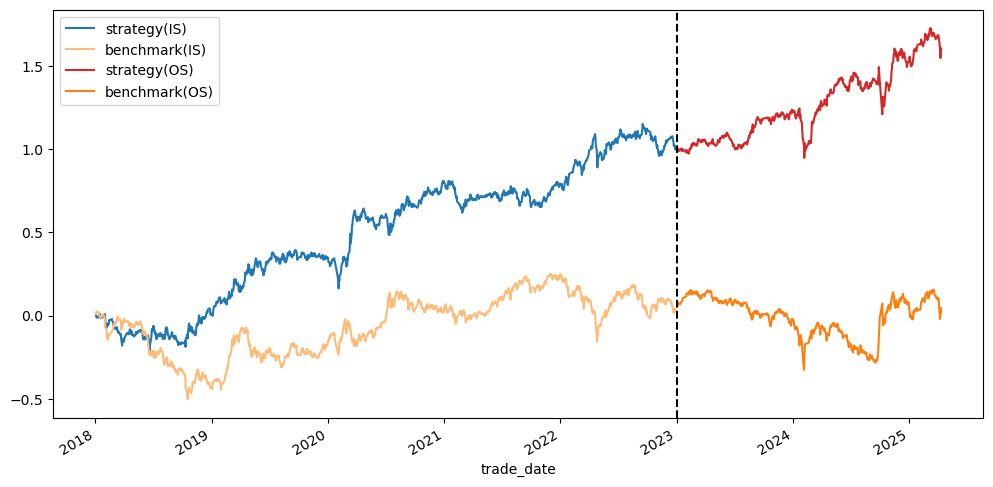

In [ ]:
# %load BetaTest.py
import numpy as np
import pandas as pd
from BetaModules import DailyCTA

cfg = {'startdate': '20180101',
       'enddate': '20250411',
       'signal_id': 'timing2_v1',
       # 'zone': 'hk',
       'trade_price': 'open',
       'slippage': 1,
       'fee': 0.000023,
       'instruments': ['zz1000'],
       'mode': 0
       }

backtest = DailyCTA(cfg)
backtest()
# backtest.get_pnl()
# backtest.profit_ana()
backtest.plot_curve(os_startdate='20230101')
# backtest.plot_curve()

In [11]:
signal = backtest.df_signal['zz1000']
pnl = backtest.pnl['pnl'].shift(-2)
bars = backtest.data_dict['zz1000']
idx_win = pnl>0
idx_los = pnl<0
idx_1 = signal>0
idx_2 = signal<0

In [ ]:
print(f"winrate of long: {(pnl[idx_1]>0).mean()}, short: {(pnl[idx_2]>0).mean()}")
print(f"odd of long: {-pnl[idx_1&idx_win].mean()/pnl[idx_1&idx_los].mean()}, short: {-pnl[idx_2&idx_win].mean()/pnl[idx_2&idx_los].mean()}")
print(f"profit of long: {pnl[idx_1].mean()}, short: {pnl[idx_2].mean()}, std of long: {pnl[idx_1].std()}, short: {pnl[idx_2].std()}, skew of long: {pnl[idx_1].skew()}, short: {pnl[idx_2]}")

winrate of long: 0.5559006211180124, short: 0.5078809106830122
odd of long: 0.9027158695899634, short: 1.1342297261588348
profit of long: 0.0008113906670239121, short: 0.0008569487066129036, std of long: 0.017400605381463385, short: 0.013974118346037144, skew of long: -0.6158887106881606, short: 0.3362436302631276


In [30]:
regime = (bars['high']/bars['low']).rolling(5).mean()
group1 = regime[idx_win&idx_1].dropna(); group2 = regime[idx_los&idx_1].dropna()
print(f"regime of win: {group1.mean()}, loss: {group2.mean()}")
print(ttest_ind(group1, group2, equal_var=False))

regime of win: 1.0185720073814557, loss: 1.0172958894690523
TtestResult(statistic=2.4185593137293306, pvalue=0.01586409945150898, df=631.0038684773527)


# 市场规律统计

In [410]:
def structure_stats(fret, *states):
    state_frets = []
    counts = []; wgts = []; winrates = []; odds = []; kelly = []; avgrets = []; avgstds = []; avgsps = []
    for state in states:
        state_frets.append(eval("fret[state]"))
    for sf in state_frets:
        counts.append(len(sf))
        wgts.append('{:.2%}'.format(len(sf)/len(fret)))
        avgrets.append('{:.4%}'.format(sf.mean()))
        if sf.mean()>0:
            odd = -sf[sf>0].mean()/sf[sf<0].mean()
            winr = (sf>0).mean()
        else:
            odd = -sf[sf<0].mean()/sf[sf>0].mean()
            winr = (sf<0).mean()
        winrates.append('{:.2%}'.format(winr))
        odds.append('{:.4f}'.format(odd))
        kelly.append('{:.4f}'.format(winr*odd-(1-winr)))
        avgstds.append('{:.2%}'.format(sf.std()))
        avgsps.append('{:.2f}'.format(np.abs(sf.mean()/sf.std())))
    print(pd.DataFrame({'count': counts, 'wgt': wgts, 'avgret': avgrets, 'avgstd': avgstds, 'winr': winrates, 'odd': odds, 'kelly': kelly, 'avg sp': avgsps}, index=np.arange(1, len(states)+1)))

def annual_stat(fret, state):
    df = pd.DataFrame({'fret': fret[state]})
    ann_num = pd.DataFrame({'fret': fret, 'year': fret.index.str[:4]}).groupby('year')['fret'].count()
    df['year'] = df.index.str[:4]
    group = df.groupby('year')['fret']
    count = group.count()
    wgt = count / ann_num
    avgret = group.mean()
    avgstd = group.std()
    if df['fret'].mean()>0:
        winr = group.apply(lambda x: (x>0).mean())
        odd = group.apply(lambda x: -x[x>0].mean()/x[x<0].mean())
    else:
        winr = group.apply(lambda x: (x<0).mean())
        odd = group.apply(lambda x: -x[x<0].mean()/x[x>0].mean())
    kelly = winr*odd - (1-winr)
    avgsp = avgret/avgstd
    wgt = wgt.map(lambda x: '{:.2%}'.format(x))
    avgret = avgret.map(lambda x: '{:.4%}'.format(x))
    avgstd = avgstd.map(lambda x: '{:.2%}'.format(x))
    winr = winr.map(lambda x: '{:.2%}'.format(x))
    odd = odd.map(lambda x: '{:.4f}'.format(x))
    kelly = kelly.map(lambda x: '{:.2f}'.format(x))
    avgsp = avgsp.map(lambda x: '{:.2f}'.format(x))
    print(pd.DataFrame({'count': count, 'wgt': wgt, 'avgret': avgret, 'avgstd': avgstd, 'winr': winr, 'odd': odd, 'kelly': kelly, 'avg sp': avgsp}))

In [ ]:
df = pd.read_pickle('./data/zz1000.pkl')
df = df.loc[(df.index<='20221231')&(df.index>='20180101')]
day = 1
fret = df['open'].pct_change(day).shift(-day-1)
dp = df['low'].pct_change()
l5 = dp.rolling(5).sum(); c5 = df['pct_change'].rolling(5).sum()
l10 = dp.rolling(10).sum(); c10 = df['pct_change'].rolling(10).sum()
cols = ['high', 'low', 'close', 'open']; qstate = df[cols].skew(1)
cn5 = df['pct_change'].rolling(5).apply(lambda x: np.sign(x).sum()); cn10 = df['pct_change'].rolling(10).apply(lambda x: np.sign(x).sum())
ln10 = dp.rolling(10).apply(lambda x: np.sign(x).sum()); ln5 = dp.rolling(5).apply(lambda x: np.sign(x).sum())
f1 = df['volume']-df['volume'].rolling(5).mean()
state1 = (ln10>0)&(l5<0)
state2 = (ln10>0)&(l5>0)
state3 = (ln10>0)&(l5>0)&(qstate>0)
state4 = (ln10>0)&(l5>0)&(qstate<=0)
state5 = (ln10>0)&(l5>0)&(qstate<=0)&(f1>0)
state6 = (ln10>0)&(l5>0)&(qstate<=0)&(f1<=0)
structure_stats(fret, *(state1, state2, state3, state4, state5, state6))
# annual_stat(fret, state4)

   count     wgt    avgret avgstd    winr     odd   kelly avg sp
1    106   8.72%   0.1318%  1.36%  50.94%  1.2463  0.1444   0.10
2    344  28.31%   0.1092%  1.26%  54.36%  1.0596  0.1196   0.09
3    157  12.92%   0.2464%  1.24%  60.51%  1.1248  0.2857   0.20
4    187  15.39%  -0.0060%  1.27%  50.80%  0.9806  0.0062   0.00
5     97   7.98%   0.1617%  1.31%  46.39%  1.6035  0.2078   0.12
6     90   7.41%  -0.1867%  1.21%  47.78%  1.6562  0.2691   0.15


# 不同因子对比

------------------------backtesting multitiming-----------------------
                        ret        sp         dd  dd_start    dd_end  \
from     to                                                            
20180102 20181228  5.967794  0.509274   8.757476  20180504  20181019   
20190102 20191231  8.574454  1.133569   8.740601  20190213  20190408   
20200102 20201231  0.711212  0.080248   8.668871  20200311  20200819   
20210104 20211231  4.473060  0.829977   4.463277  20210104  20210208   
20220104 20221230  8.146643  0.782838  12.492901  20220228  20220427   
20180102 20221230  5.574337  0.616663  12.492901  20220228  20220427   

                      anntvr       winr       odd    calmar  
from     to                                                  
20180102 20181228  67.147463  57.201646  0.833610  0.681451  
20190102 20191231  80.355775  50.819672  1.217893  0.980991  
20200102 20201231  82.596240  51.028807  0.976338  0.082042  
20210104 20211231  81.872928  49.794239  1

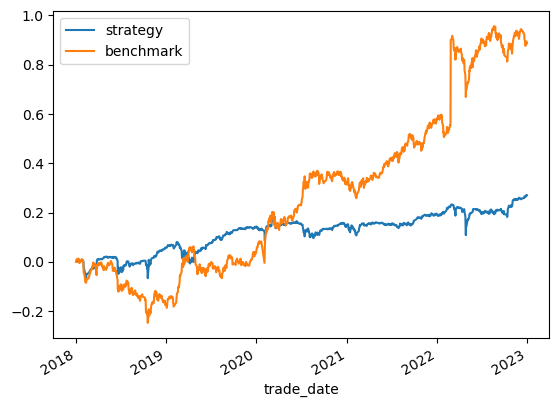

In [34]:
# %load MultiBetaTest.py
import numpy as np
import pandas as pd
from MultiBetaModules import BackTest

cfg = {'startdate': '20180101',
       'enddate': '20221231',
       'signal_id': 'multitiming',
       'mode': 0
       }

backtest = BackTest(cfg)
backtest()
# backtest.get_pnl()
# backtest.profit_ana()
backtest.plot_curve()

In [447]:
cfg = {'startdate': '20180101',
       'enddate': '20221231',
       'signal_id': 'timing1_v1',
       # 'zone': 'hk',
       'trade_price': 'open',
       'slippage': 1,
       'fee': 0.000023,
       'instruments': ['zz1000'],
       'mode': 0
       }

backtest_is = DailyCTA(cfg)
backtest_is()
cfg = {'startdate': '20230101',
       'enddate': '20250411',
       'signal_id': 'timing1_v1',
       # 'zone': 'hk',
       'trade_price': 'open',
       'slippage': 1,
       'fee': 0.000023,
       'instruments': ['zz1000'],
       'mode': 0
       }

backtest_os = DailyCTA(cfg)
backtest_os()

--------------backtesting timing1_v1--------------
                         ret        sp        dd  dd_start    dd_end  \
from     to                                                            
20180102 20181228  -4.913127 -0.557253  9.200382  20180129  20180821   
20190102 20191231  20.266313  1.572560  8.574324  20190530  20191203   
20200102 20201231  25.870811  2.395917  3.371600  20200305  20200331   
20210104 20211231   7.471000  1.272106  2.747614  20210104  20210226   
20220104 20221230  17.448817  2.123261  4.669519  20220905  20221101   
20180102 20221230  13.246027  1.375415  9.200382  20180129  20180821   

                      anntvr       winr       odd    calmar  
from     to                                                  
20180102 20181228  52.685950  57.692308  0.577925 -0.534013  
20190102 20191231  70.696721  67.647059  0.983767  2.363605  
20200102 20201231  37.037037  83.333333  1.066270  7.673155  
20210104 20211231  42.181070  61.904762  1.292565  2.719087  


In [446]:
cfg = {'startdate': '20180101',
       'enddate': '20221231',
       'signal_id': 'timing2_v1',
       # 'zone': 'hk',
       'trade_price': 'open',
       'slippage': 1,
       'fee': 0.000023,
       'instruments': ['zz1000'],
       'mode': 0
       }

backtest2_is = DailyCTA(cfg)
backtest2_is()
cfg = {'startdate': '20230101',
       'enddate': '20250411',
       'signal_id': 'timing2_v1',
       # 'zone': 'hk',
       'trade_price': 'open',
       'slippage': 1,
       'fee': 0.000023,
       'instruments': ['zz1000'],
       'mode': 0
       }

backtest2_os = DailyCTA(cfg)
backtest2_os()

--------------backtesting timing2_v1--------------
                         ret        sp        dd  dd_start    dd_end  \
from     to                                                            
20180102 20181228  -0.013397 -0.002916  3.892774  20180103  20180517   
20190102 20191231  10.439798  1.290595  4.552427  20190626  20190821   
20200102 20201231  16.616471  1.876920  3.301644  20200427  20200729   
20210104 20211231   8.458874  1.067667  5.579240  20210309  20210719   
20220104 20221230   6.632137  1.055421  2.429036  20220916  20221107   
20180102 20221230   8.436866  1.154295  5.579240  20210309  20210719   

                      anntvr       winr       odd    calmar  
from     to                                                  
20180102 20181228  35.123967  35.294118  1.918899 -0.003441  
20190102 20191231  40.983607  65.000000  1.197728  2.293238  
20200102 20201231  41.152263  65.000000  2.312157  5.032787  
20210104 20211231  49.382716  50.000000  1.659870  1.516134  


In [390]:
pnl1_is = backtest_is.pnl['pnl']
pnl1_os = backtest_os.pnl['pnl']
pnl2_is = backtest2_is.pnl['pnl']
pnl2_os = backtest2_os.pnl['pnl']
print(pnl1_is.corr(pnl2_is), pnl1_os.corr(pnl2_os))

0.9222960573757648 0.8806498564670634


# 交易对胜率提升

In [ ]:
# df = pd.read_pickle('./data/[v2交易对stk]无强制闭环_20241207.pkl')
# df = df[df.factor_date>=pd.to_datetime('20200101')].reset_index(drop=True)

alpha = pd.read_pickle('./dump/alpha5_v1.pkl')
alpha.index = pd.to_datetime(alpha.index)
alpha = alpha.rank(axis=1, method='dense', pct=True)
alpha_ts = alpha.stack().reset_index()
alpha_ts.columns = ['factor_date', 'code', 'alpha']

df1 = df.merge(alpha_ts, on=['code', 'factor_date'], how='left')
# low = (df1.loc[df1['alpha']<0.33, 'return']>0).mean()
low = len(df1.loc[df1['alpha']<0.33, 'return'])/len(df1)
# med = (df1.loc[(df1['alpha']>=0.33)&(df1['alpha']<0.67), 'return']>0).mean()
med = len(df1.loc[(df1['alpha']>=0.33)&(df1['alpha']<0.67), 'return'])/len(df1)
# high = (df1.loc[df1['alpha']>=0.67, 'return']>0).mean()
high = len(df1.loc[df1['alpha']>=0.67, 'return'])/len(df1)
# print(low, med, high)

df1['year'] = df1['factor_date'].dt.year
gpdf = df1.groupby('year')[['alpha', 'return']]
# glow = gpdf.apply(lambda x: (x.loc[x['alpha']<0.33, 'return']>0).mean())
glow = gpdf.apply(lambda x: len(x.loc[x['alpha']<0.33, 'return'])/len(x))
# gmed = gpdf.apply(lambda x: (x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return']>0).mean())
gmed = gpdf.apply(lambda x: len(x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return'])/len(x))
# ghigh = gpdf.apply(lambda x: (x.loc[x['alpha']>=0.67, 'return']>0).mean())
ghigh = gpdf.apply(lambda x: len(x.loc[x['alpha']>=0.67, 'return'])/len(x))
winr = pd.concat([glow, gmed, ghigh], axis=1)
winr.loc['total'] = [low, med, high]
winr

,0,1,2
year,,,
2020,0.322534,0.326782,0.333905
2021,0.304893,0.321943,0.345101
2022,0.312623,0.326590,0.331028
2023,0.304770,0.327519,0.346681
2024,0.309977,0.330352,0.342939
total,0.310492,0.326881,0.340164


In [61]:
df1['alpha'].max()

1.0

In [51]:
gpdf = df1.groupby('year')[['alpha', 'return']]
glow = gpdf.apply(lambda x: (x.loc[x['alpha']<0.33, 'return']>0).mean())
gmed = gpdf.apply(lambda x: (x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return']>0).mean())
ghigh = gpdf.apply(lambda x: (x.loc[x['alpha']>=0.67, 'return']>0).mean())
winr = pd.concat([glow, gmed, ghigh], axis=1)
winr.loc['total'] = [low, med, high]
winr

,0,1,2
year,,,
2020,0.550949,0.626096,0.653644
2021,0.586117,0.664708,0.712891
2022,0.508964,0.570291,0.593755
2023,0.553629,0.621106,0.642564
2024,0.544156,0.589528,0.589219
total,0.546956,0.611181,0.634199


In [ ]:
gpdf = df1.groupby('year')[['alpha', 'return']]
glow = gpdf.apply(lambda x: (x.loc[x['alpha']<0.33, 'return']>0).mean())
gmed = gpdf.apply(lambda x: (x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return']>0).mean())
ghigh = gpdf.apply(lambda x: (x.loc[x['alpha']>=0.67, 'return']>0).mean())
winr = pd.concat([glow, gmed, ghigh], axis=1)
winr.loc['total'] = [low, med, high]
winr

,0,1,2
year,,,
2020,0.550949,0.626096,0.653644
2021,0.586117,0.664708,0.712891
2022,0.508964,0.570291,0.593755
2023,0.553629,0.621106,0.642564
2024,0.544156,0.589528,0.589219
total,0.546956,0.611181,0.634199


In [28]:
df1['factor_date'].dt.year

0          2020
1          2020
2          2020
3          2020
4          2020
           ... 
1336627    2024
1336628    2024
1336629    2024
1336630    2024
1336631    2024
Name: factor_date, Length: 1336632, dtype: int32

In [12]:
macro = pd.read_csv('./data/缓存s_dq_close_ma5加s_dq_close_ma10去1月胜率加5pct.csv')
# macro['code'] = macro['code_date'].str[:9]
macro['factor_date'] = pd.to_datetime(macro['factor_date'], format='%Y%m%d')
macro = macro[['code', 'factor_date']]
macro

,code,factor_date
0,000002.SZ,2014-02-07
1,000048.SZ,2014-02-07
2,000059.SZ,2014-02-07
3,000423.SZ,2014-02-07
4,000538.SZ,2014-02-07
...,...,...
1572845,301335.SZ,2024-12-05
1572846,688426.SH,2024-12-05
1572847,688502.SH,2024-12-05
1572848,688506.SH,2024-12-05


In [13]:
df2 = df1.merge(macro, on=['code', 'factor_date'], how='inner')
sub2 = df2.loc[df2['alpha']>0.1, 'return']
(sub2>0).mean()

0.6666019310073565

In [14]:
df2.shape

(898958, 26)

In [15]:
(1336632-898958)/1336632

0.32744540008020157

In [27]:

df['return'].mean()

0.0017807397389782405

In [16]:
(df['return']>0).mean()

0.5988185229741619

In [23]:
def aaa(b: int):
    print(b+1)

aaa('3')

TypeError: can only concatenate str (not "int") to str

In [5]:
list_date = pd.read_pickle('./data/list_date.pkl')
list_date

,code,listdate,delistdate
0,000004.SZ,19901201,21001231
1,000005.SZ,19901210,20240426
2,600653.SH,19901219,21001231
3,600651.SH,19901219,21001231
4,600602.SH,19901219,21001231
...,...,...,...
5664,301617.SZ,20241211,21001231
5665,688605.SH,20241212,21001231
5666,920106.BJ,20241218,21001231
5667,301585.SZ,20241220,21001231


In [20]:
df = pd.read_pickle('./data/close.pkl')
df = df[df.index>='20240101']
df.to_csv('./data/close.csv')

In [7]:
didx = trade_date.index.values.reshape(-1, 1)
lidx = list_date['list_index'].values.reshape(1, -1)
listdays = np.maximum(didx - lidx, 0)
listdays = pd.DataFrame(listdays, index=trade_date.values, columns=list_date['code'].values)
listdays

,000004.SZ,000005.SZ,600653.SH,600651.SH,600602.SH,600656.SH,600654.SH,600652.SH,600601.SH,000002.SZ,...,920128.BJ,688449.SH,301622.SZ,688708.SH,920098.BJ,301617.SZ,688605.SH,920106.BJ,301585.SZ,301598.SZ
20070104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20070105,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
20070108,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
20070109,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
20070110,4,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20241225,4370,4370,4370,4370,4370,4370,4370,4370,4370,4370,...,18,18,15,14,14,10,9,5,3,3
20241226,4371,4371,4371,4371,4371,4371,4371,4371,4371,4371,...,19,19,16,15,15,11,10,6,4,4
20241227,4372,4372,4372,4372,4372,4372,4372,4372,4372,4372,...,20,20,17,16,16,12,11,7,5,5
20241230,4373,4373,4373,4373,4373,4373,4373,4373,4373,4373,...,21,21,18,17,17,13,12,8,6,6


In [9]:
index = listdays.index[(listdays.index>=20170101)&(listdays.index<=20241220)]

In [10]:
pnl = pd.DataFrame({'nav': np.random.randn(len(index))}, index=index)
pnl['year'] = pnl.index//10000
gpnl = pnl.groupby('year')
pnl['dd'] = gpnl['nav'].cummax()-pnl['nav']
dd_y = gpnl['dd'].max()

In [95]:
df = pd.DataFrame(np.random.rand(5,5))
df.iloc[1, 4] = np.nan
df.iloc[2, 2] = np.nan
dfs = df.stack()
dfs.iloc[-1]

0.4783777764640592

In [90]:
dd_y.rank(pct=True)

year
2017    0.375
2018    0.125
2019    0.250
2020    0.875
2021    0.625
2022    0.500
2023    1.000
2024    0.750
Name: dd, dtype: float64

In [21]:
index1 = gpnl.head(1).index
index2 = gpnl.tail(1).index
out = pd.DataFrame({'dd': dd_y.values}, index=pd.MultiIndex.from_arrays([index1, index2], names=['from', 'to']))
out.loc[(20170101, 20241220), :] = 0.5
out

,,dd
from,to,
20170103,20171229,5.353578
20180102,20181228,5.091181
20190102,20191231,5.265294
20200102,20201231,5.937161
20210104,20211231,5.594151
20220104,20221230,5.359023
20230103,20231229,6.027280
20240102,20241220,5.758448
20170101,20241220,0.500000


In [96]:
np.sign(out)

,,dd
from,to,
20170103,20171229,1.0
20180102,20181228,1.0
20190102,20191231,1.0
20200102,20201231,1.0
20210104,20211231,1.0
20220104,20221230,1.0
20230103,20231229,1.0
20240102,20241220,1.0
20170101,20241220,1.0


In [168]:
dd = pd.DataFrame(gpnl['nav'].cummax() - pnl['nav'], columns=['nav'], index=pnl.index)
dd['year'] = pnl['year']
dd.groupby('year')['nav'].max()

year
2017    4.790396
2018    5.110988
2019    5.523158
2020    5.976734
2021    5.317251
2022    5.655704
2023    4.585310
2024    5.563374
Name: nav, dtype: float64

In [22]:
df = pd.DataFrame(np.random.rand(10, 10))
df[df > 0.5] -= 1

In [41]:
alpha = pd.read_pickle('./alpha/alpha1_v1.pkl')
alpha = alpha.loc[alpha.index>=20170101]
# alpha = alpha.rank(1, method='dense', pct=True)



In [67]:
rk = alpha.rank(1, method='dense', pct=True) - 0.5
w = rk.div(rk.abs().sum(1), axis=0)
rk.subtract(rk.mean(1), axis=0)

code,000004.SZ,000005.SZ,600601.SH,600653.SH,600652.SH,600651.SH,600602.SH,600654.SH,600656.SH,000002.SZ,...,301622.SZ,920098.BJ,688708.SH,301617.SZ,688605.SH,920106.BJ,301585.SZ,301598.SZ,603194.SH,920082.BJ
trade_date,,,,,,,,,,,,,,,,,,,,,
20170103,-0.226030,0.365404,0.123691,0.165404,0.317732,0.032071,0.315497,0.460376,NaN,0.030954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170104,0.161586,-0.501871,0.004482,-0.519969,0.226661,0.255156,0.356812,0.445375,NaN,0.083804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170105,-0.355451,-0.045043,0.284651,-0.010109,-0.255014,0.382177,0.229702,0.471333,NaN,0.034651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170106,-0.109492,-0.090047,0.363680,-0.004343,0.409053,0.397530,0.016183,0.475312,NaN,0.049312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170109,-0.457366,-0.033100,0.332009,0.453712,0.284910,-0.151789,0.402469,0.453712,NaN,0.242333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20241220,-0.398840,NaN,-0.111486,0.140475,NaN,-0.139227,0.223314,0.390331,NaN,-0.182655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20241223,-0.403609,NaN,0.000226,-0.082684,NaN,-0.461703,-0.340252,0.090656,NaN,0.371160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20241224,-0.240836,NaN,0.014362,-0.091954,NaN,0.317422,-0.130401,-0.141189,NaN,0.474935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
rk.iloc[:, 0].ewm(span=3, adjust=False).mean()

trade_date
20170103   -0.186406
20170104    0.014903
20170105   -0.155940
20170106   -0.120372
20170109   -0.265725
              ...   
20241220   -0.102283
20241223   -0.250756
20241224   -0.233264
20241225    0.133368
20241226   -0.128912
Name: 000004.SZ, Length: 1940, dtype: float64

In [87]:
dict = {'EmaDecay': 1, 'RiskNeut': 2, 'NLRiskNeut': 3}
for k in dict.keys():
    print(k)
print(f"self.'{k}'")

EmaDecay
RiskNeut
NLRiskNeut
self.'NLRiskNeut'
